# Polars v Pandas
Estudio de rendimiento entre las dos librerías dedicadas al trabajo con conjuntos de datos.

Se verá el estudio de tiempo, rendimiento, memoria, etc.

In [ ]:
# En caso de no tener instalados los paquetes
%pip install pandas
%pip install polars
%pip install numpy

In [89]:
import pandas as pd
import polars as pl
import numpy as np
import time
import tracemalloc

from typing import Callable
import matplotlib.pyplot as plt

In [90]:
# generamos un conjunto de datos grande (aqui podemos cambiar el tamaño para mejorar el rendimiento)
np.random.seed(69)
data_size = 1_000_000
df_data = {
    'id': np.arange(data_size),
    'category': np.random.choice(['A', 'B', 'C', 'D'], size=data_size),
    'value': np.random.rand(data_size)*100,
    'text': np.random.choice(['Lorem ipsum', 'Dolor sit amet', 'Consectetur adipiscing', 'Elit'], size=data_size)
}

In [91]:
# Función para medir el tiempo y memoria de una operación
def measure_performance(func : Callable, *args, **kwargs):
    # Iniciar medición de memoria
    tracemalloc.start()

    # Medir el tiempo
    start_time = time.time()
    result = func(*args, **kwargs)
    elapsed_time = time.time() - start_time

    # Medición de memoria
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return result, elapsed_time, current, peak

### CARGA DE DATOS

In [92]:
# carga de datos
_, pandas_load_time, pandas_mem_current, pandas_mem_peak = measure_performance(pd.DataFrame, df_data)
_, polars_load_time, polars_mem_current, polars_mem_peak = measure_performance(pl.DataFrame, df_data)

In [93]:
print(pandas_mem_peak, polars_mem_peak)

137765362 2276


### FILTRADO DE FILAS

In [94]:
def pandasfilter(df : pd.DataFrame) -> pd.DataFrame:
    return df[df['value'] > 50]

def polarsfilter(df : pl.DataFrame) -> pl.DataFrame:
    return df.filter(pl.col('value') > 50)

In [95]:
# filtrado de filas
_, pandas_filter_time, _, _ = measure_performance(pandasfilter, pd.DataFrame(df_data))
_, polars_filter_time, _, _ = measure_performance(polarsfilter, pl.DataFrame(df_data))

In [96]:
print('Pandas', 'Polars')
print(pandas_filter_time, polars_filter_time)

Pandas Polars
0.02506232261657715 0.009569644927978516


### AGRUPACIÓN Y CALCULO DE ESTADISTICAS

In [97]:
def pandasgroupby(df : pd.DataFrame) -> pd.DataFrame:
    return df.groupby(by='category')['value'].mean().reset_index()

def polarsgroupby(df : pl.DataFrame) -> pl.DataFrame:
    return df.group_by('category').agg([pl.mean('value').alias('mean')])

In [98]:
_, pandas_groupby_time, _, _ = measure_performance(pandasgroupby, pd.DataFrame(df_data))
_, polars_groupby_time, _, _ = measure_performance(polarsgroupby, pl.DataFrame(df_data))

In [99]:
print('Pandas', 'Polars')
print(pandas_groupby_time, polars_groupby_time)

Pandas Polars
0.04003643989562988 0.022310972213745117


### TRANSFORMACIÓN DE TEXTO

In [100]:
def pandastext(df : pd.DataFrame) -> pd.DataFrame:
    return df['text'].apply(lambda x: x.lower())


def polarstext(df : pl.DataFrame) -> pl.DataFrame:
    return df.with_columns(pl.col('text').str.to_lowercase())

In [101]:
_, pandas_text_time, _, _ = measure_performance(pandastext, pd.DataFrame(df_data))
_, polars_text_time, _, _ = measure_performance(polarstext, pl.DataFrame(df_data))

In [102]:
print('Pandas', 'Polars')
print(pandas_text_time, polars_text_time)

Pandas Polars
1.846334457397461 0.08416199684143066


## Estudio general para comparar dependiendo del largo del dataframe

In [103]:
# valuamos las diferentes funciones en varios dataframes con distintas longitudes
np.random.seed(69)
performance = {
    'order': [],
    'data_size': [],
    'test': [],
    'pandas_time': [],
    'polars_time': []
}
space = {
    'order': [],
    'data_size': [],
    'pandas': [],
    'polars': []
}
for order in range(8):
    data_size = 10**order
    df_data = pd.DataFrame({
        'id': np.arange(data_size),
        'category': np.random.choice(['A', 'B', 'C', 'D'], size=data_size),
        'value': np.random.rand(data_size)*100,
        'text': np.random.choice(['Lorem ipsum', 'Dolor sit amet', 'Consectetur adipiscing', 'Elit'], size=data_size)
    })

    # carga de datos
    _, pandas_load_time, pandas_mem_current, pandas_mem_peak = measure_performance(pd.DataFrame, df_data)
    _, polars_load_time, polars_mem_current, polars_mem_peak = measure_performance(pl.DataFrame, df_data)
    performance['order'].append(order)
    performance['data_size'].append(data_size)
    performance['test'].append('load')
    performance['pandas_time'].append(pandas_load_time/(1024**2))
    performance['polars_time'].append(polars_load_time/(1024**2))
    # agregamos el performance del espacio
    space['order'].append(order)
    space['data_size'].append(data_size)
    space['pandas'].append(pandas_mem_peak)
    space['polars'].append(polars_mem_peak)


    # filtro de datos
    _, pandas_filter_time, _, _ = measure_performance(pandasfilter, pd.DataFrame(df_data))
    _, polars_filter_time, _, _ = measure_performance(polarsfilter, pl.DataFrame(df_data))
    performance['order'].append(order)
    performance['data_size'].append(data_size)
    performance['test'].append('filter')
    performance['pandas_time'].append(pandas_filter_time)
    performance['polars_time'].append(polars_filter_time)

    # agrupación
    _, pandas_groupby_time, _, _ = measure_performance(pandasgroupby, pd.DataFrame(df_data))
    _, polars_groupby_time, _, _ = measure_performance(polarsgroupby, pl.DataFrame(df_data))
    performance['order'].append(order)
    performance['data_size'].append(data_size)
    performance['test'].append('group')
    performance['pandas_time'].append(pandas_groupby_time)
    performance['polars_time'].append(polars_groupby_time)

    # transformacion de texto 
    _, pandas_text_time, _, _ = measure_performance(pandastext, pd.DataFrame(df_data))
    _, polars_text_time, _, _ = measure_performance(polarstext, pl.DataFrame(df_data))
    performance['order'].append(order)
    performance['data_size'].append(data_size)
    performance['test'].append('text')
    performance['pandas_time'].append(pandas_text_time)
    performance['polars_time'].append(polars_text_time)

In [104]:
df_per = pd.DataFrame(performance)

In [105]:
df_per['test'].unique()

array(['load', 'filter', 'group', 'text'], dtype=object)

In [106]:
test = 'text'
print(df_per[df_per['test'] == test]['pandas_time'].max())
print(df_per[df_per['test'] == test]['polars_time'].max())

19.527755975723267
0.9122748374938965


In [107]:
df_per.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   order        32 non-null     int64  
 1   data_size    32 non-null     int64  
 2   test         32 non-null     object 
 3   pandas_time  32 non-null     float64
 4   polars_time  32 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.4+ KB


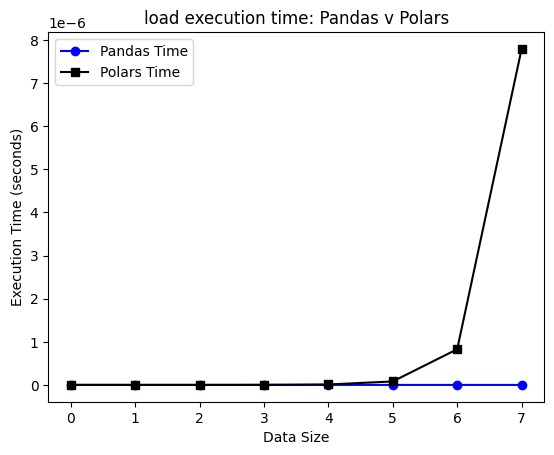

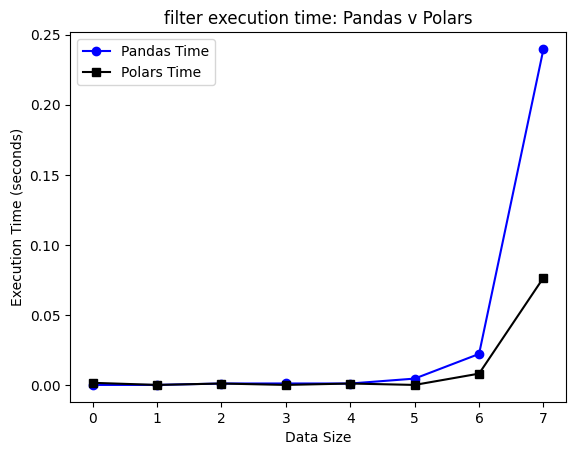

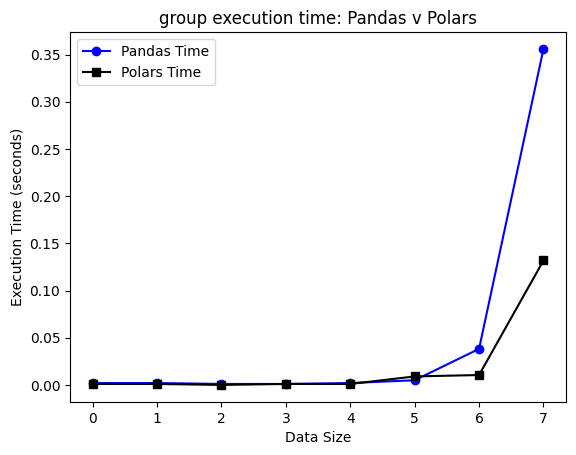

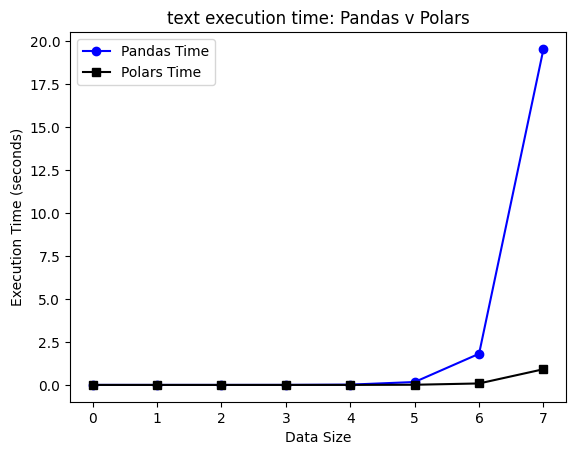

In [111]:
tests = ['load', 'filter', 'group', 'text']
for test in tests: 
    df = df_per[df_per['test'] == test]
    plt.plot(df['order'], df['pandas_time'], label='Pandas Time', marker='o', color='blue')
    plt.plot(df['order'], df['polars_time'], label='Polars Time', marker='s', color='black')

    plt.xlabel('Data Size')
    plt.ylabel('Execution Time (seconds)')
    plt.title(f'{test} execution time: Pandas v Polars')


    plt.legend()

    plt.show()


In [109]:
dfsp = pd.DataFrame(space)

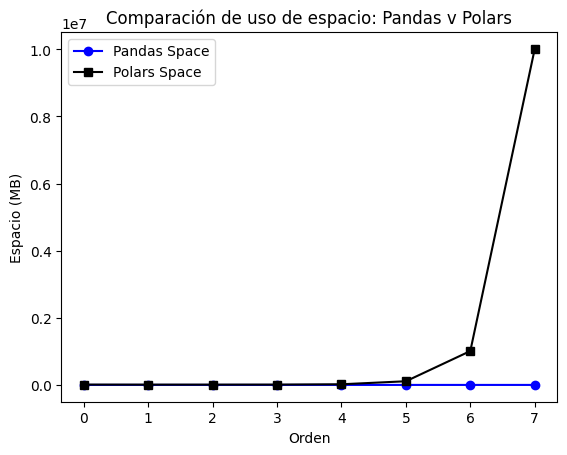

In [110]:
plt.plot(dfsp['order'], dfsp['pandas'], label='Pandas Space', marker='o', color='blue')
plt.plot(dfsp['order'], dfsp['polars'], label='Polars Space', marker='s', color='black')

plt.xlabel('Orden')
plt.ylabel('Espacio (MB)')
plt.title('Comparación de uso de espacio: Pandas v Polars')

plt.legend()

plt.show()